In [13]:
import numpy as np
from scipy.sparse.linalg import eigsh
from openfermionpyscf import run_pyscf
from openfermion import MolecularData, get_fermion_operator
from openfermion.linalg import get_sparse_operator




In [14]:
def fermion_to_qubit(problem, second_q_op, mapper_name):
    if mapper_name == "JW":
        mapper = JordanWignerMapper()
    if mapper_name == "Pa":
        mapper = ParityMapper(num_particles=problem.num_particles)
    if mapper_name == "BK":
        mapper = BravyiKitaevMapper()
    qubit_op = mapper.map(second_q_op)
    return qubit_op , mapper

def indices_with_N_and_Sz0(n_qubits, n_elec):
    """전자수=N 이면서 S_z=0 (interleaved: 짝수=alpha, 홀수=beta)"""
    idx = []
    for s in range(1 << n_qubits):
        if s.bit_count() != n_elec:
            continue
        n_alpha = sum((s >> i) & 1 for i in range(0, n_qubits, 2))  # 0,2,4,...
        n_beta  = sum((s >> i) & 1 for i in range(1, n_qubits, 2))  # 1,3,5,...
        if n_alpha == n_beta:
            idx.append(s)
    return np.array(idx, dtype=int)

In [15]:
import numpy as np
from scipy.sparse import issparse, csr_matrix, csc_matrix, coo_matrix, eye, block_diag
from scipy.sparse.csgraph import connected_components

def block_diagonalize_by_permutation(A, *, symmetrize=True, tol=0.0, return_P=False):
    """
    하나의 희소행렬 A를 순열행렬 P로 블록 대각화:
      A_perm = P.T @ A @ P  가 block-diagonal 이 되도록 한다.
    
    Parameters
    ----------
    A : (n,n) scipy.sparse matrix or ndarray
        대각화할 정방 희소행렬 (CSR/CSC/COO 권장).
    symmetrize : bool, default True
        그래프를 만들 때 |A|의 패턴을 A + A.T 로 대칭화(무향 그래프).
        (비대칭 행렬이라도 의존성 측면에선 무향으로 보는 게 일반적)
    tol : float, default 0.0
        |A_ij| <= tol 인 항은 0으로 간주 (숫자 노이즈 제거용).
    return_P : bool, default False
        순열행렬 P 자체를 반환할지 여부. (대형 문제에선 비추천; 인덱스만 써도 충분)
    
    Returns
    -------
    A_perm : scipy.sparse.csr_matrix
        재정렬 후의 블록 대각 행렬(실제로는 블록 대각 형태).
    blocks : list[scipy.sparse.csr_matrix]
        각 블록의 서브행렬들 (A_perm 의 대각 블록).
    perm : np.ndarray (shape (n,))
        재정렬에 사용된 인덱스. A_perm = A[perm, :][:, perm].
    P : scipy.sparse.csr_matrix (optional)
        (return_P=True 인 경우) 순열행렬. 그렇지 않으면 미반환.
    """
    # 0) 스파스로 통일
    if not issparse(A):
        A = csr_matrix(A)
    else:
        A = A.tocsr()

    n = A.shape[0]
    if A.shape[0] != A.shape[1]:
        raise ValueError("A must be square.")

    # 1) 아주 작은 값 제거 (선택)
    if tol > 0.0:
        A = A.copy()
        A.data[np.abs(A.data) <= tol] = 0.0
        A.eliminate_zeros()

    # 2) 그래프 인접행렬 구성 (무향 권장)
    #    연결 성분을 찾기 위해 대칭 패턴으로 보는 것이 보통 안전함.
    if symmetrize:
        # 패턴 합치기: |A| + |A^T|  (부호는 의미 없고, 연결만 중요)
        G = (A != 0).astype(np.int8)
        GT = (A.T != 0).astype(np.int8)
        Adj = (G + GT).astype(bool).astype(np.int8)
        # 자기자신 연결 제거(connected_components는 대각선은 무시해도 큰 상관 없음)
        Adj.setdiag(0)
        Adj.eliminate_zeros()
    else:
        # 방향 그래프의 연결성(약연결/강연결)을 따지고 싶다면 별도 처리 필요
        # 여기선 간단히 비대칭 그대로 사용 (비추천)
        Adj = (A != 0).astype(np.int8)
        Adj.setdiag(0)
        Adj.eliminate_zeros()

    # 3) 연결 성분 분해
    #    return_labels=True 이면 각 정점이 어느 성분에 속하는지 라벨 반환
    n_comp, labels = connected_components(Adj, directed=False, connection='weak')

    # 4) 각 성분별로 인덱스 모으고, 그 순서로 전체 perm 구성
    comp_indices = [np.where(labels == k)[0] for k in range(n_comp)]
    # 블록 크기 큰 순서, 혹은 자연스러운 오름차순 등으로 정렬 가능
    comp_indices = sorted(comp_indices, key=lambda idx: idx.min())
    perm = np.concatenate(comp_indices)

    # 5) 순열 적용: A_perm = P^T A P  (행/열 인덱싱으로 충분)
    A_perm = A[perm, :][:, perm].tocsr()

    # 6) 블록 추출(슬라이스)
    blocks = []
    start = 0
    for idx in comp_indices:
        m = len(idx)
        blocks.append(A_perm[start:start+m, start:start+m].copy())
        start += m

    # 7) 선택적으로 P 반환 (대형 문제에선 메모리 낭비 가능)
    if return_P:
        P = eye(n, format='csr')[perm, :]
        return A_perm, blocks, perm, P
    else:
        return A_perm, blocks, perm

In [16]:
C = 1.9220
L = 2.0946
theta = np.deg2rad(94.24)

Co = (0,0,0)
O_1 = (C,0,0)
O_2 = (C*np.cos(theta),C*np.sin(theta),0)
Li = (C+L*np.cos(np.pi-theta),-L*np.sin(np.pi-theta),0)

In [17]:
O_Li_dimer_atoms = ["Co","O", "O", "Li"]
O_Li_dimer_coords = [Co,O_1,O_2, Li]

geometry = [("Co", Co),
            ("O", O_1),
            ("O", O_2),
            ("Li", Li)]  # Angstrom


In [18]:
dist = 1.322
geometry = [('H', (0., 0., 0.)),
            ('H', (0., 0., 0.7414 )),
            ('H', (0., 0., 0 + dist)),
            ('H', (0., 0., 0.7414 + dist))]  # Angstrom

# geometry = [("Co", Co),
#             ("O", O_1),
#             ("O", O_2),
#             ("Li", Li)]  # Angstrom

basis = 'sto-3g'
mol = MolecularData(geometry, basis, multiplicity=1, charge=0)

# 2. PySCF 실행 (SCF까지만 해도 충분)
mol = run_pyscf(mol, run_scf=1, run_fci=1)

# 3. 2차 정량화 Hamiltonian 얻기
ham_int = mol.get_molecular_hamiltonian()
ham_fci = get_fermion_operator(ham_int)

print("Number of terms:", len(ham_fci.terms))
for term, coeff in list(ham_fci.terms.items())[:10]:
    print(term, coeff)
    
    
H = get_sparse_operator(ham_fci, n_qubits=mol.n_qubits)
print(H)


# 2) N=2, S_z=0 서브스페이스 (H2/STO-3G면 4x4)
idx_N2_Sz0 = indices_with_N_and_Sz0(mol.n_qubits, n_elec=4)
print(idx_N2_Sz0)
H_N2_Sz0 = H[idx_N2_Sz0, :][:, idx_N2_Sz0].tocsr()
print(H_N2_Sz0)
print("N=2, Sz=0 block shape:", H_N2_Sz0.shape)  # (4, 4)

Number of terms: 529
() 3.395969155303167
((0, 1), (0, 0)) -2.341377471587156
((0, 1), (4, 0)) 0.21402565401395582
((1, 1), (1, 0)) -2.341377471587156
((1, 1), (5, 0)) 0.21402565401395582
((2, 1), (2, 0)) -1.793073669915166
((2, 1), (6, 0)) 0.1748537215681315
((3, 1), (3, 0)) -1.793073669915166
((3, 1), (7, 0)) 0.1748537215681315
((4, 1), (0, 0)) 0.21402565401395596
<Compressed Sparse Column sparse matrix of dtype 'complex128'
	with 2240 stored elements and shape (256, 256)>
  Coords	Values
  (0, 0)	(3.395969155303167+0j)
  (1, 1)	(2.9786623605876614+0j)
  (16, 1)	(0.1748537215681315+0j)
  (2, 2)	(2.9786623605876614+0j)
  (32, 2)	(0.1748537215681315+0j)
  (3, 3)	(3.33364890647153+0j)
  (12, 3)	(0.13882009886411778+0j)
  (18, 3)	(-0.04465024368304468+0j)
  (33, 3)	(0.04465024368304468+0j)
  (48, 3)	(0.0945803378024111+0j)
  (72, 3)	(0.05486115114811128+0j)
  (132, 3)	(-0.05486115114811128+0j)
  (192, 3)	(0.09913903798756303+0j)
  (4, 4)	(2.0352087544547417+0j)
  (64, 4)	(0.2140256540139

In [19]:
w, V = eigsh(H, k=10, which='SA') 
print(w)

[-2.0264693  -1.62848805 -1.33961018 -1.62848805 -1.25437243 -1.51179946
 -1.51179946 -1.65618154 -1.65618154 -1.65618154]


In [20]:
from scipy.sparse import csr_matrix

# 예: 0~3번은 서로 연결, 4~6번은 서로 연결 (두 블록)


A_perm, blocks, perm = block_diagonalize_by_permutation(H_N2_Sz0 )
print("perm =", perm.tolist())
print("A_perm (dense):\n", A_perm.toarray())
print("num blocks =", len(blocks))
for i, Bi in enumerate(blocks, 1):
    print(f"Block {i} shape:", Bi.shape)

perm = [0, 2, 4, 5, 8, 9, 11, 13, 14, 17, 18, 21, 22, 24, 26, 27, 30, 31, 33, 35, 1, 3, 6, 7, 10, 12, 15, 16, 19, 20, 23, 25, 28, 29, 32, 34]
A_perm (dense):
 [[ 3.25094732+0.j  0.10386288+0.j -0.10386288+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.10386288+0.j  1.5054382 +0.j -0.09458034+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [-0.10386288+0.j -0.09458034+0.j  1.5054382 +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.31635539+0.j
   0.00595177+0.j  0.10820559+0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.00595177+0.j
  -1.46747294+0.j -0.15769026+0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.10820559+0.j
  -0.15769026+0.j -1.46747294+0.j]]
num blocks = 2
Block 1 shape: (20, 20)
Block 2 shape: (16, 16)


In [21]:
print(blocks[0])

<Compressed Sparse Row sparse matrix of dtype 'complex128'
	with 316 stored elements and shape (20, 20)>
  Coords	Values
  (0, 0)	(3.250947318196569+0j)
  (0, 1)	(0.10386287796753066+0j)
  (0, 2)	(-0.10386287796753073+0j)
  (0, 3)	(0.15769026196912034+0j)
  (0, 4)	(0.0945803378024111+0j)
  (0, 5)	(0.008345131608166743+0j)
  (0, 6)	(-0.06414921172182608+0j)
  (0, 7)	(-0.023172392700854506+0j)
  (0, 8)	(0.08732160442268058+0j)
  (0, 10)	(-0.008345131608166783+0j)
  (0, 11)	(0.08732160442268058+0j)
  (0, 12)	(-0.023172392700854506+0j)
  (0, 13)	(-0.06414921172182608+0j)
  (0, 15)	(0.10514827807117566+0j)
  (0, 16)	(0.09913903798756303+0j)
  (1, 0)	(0.10386287796753046+0j)
  (1, 1)	(1.505438202234533+0j)
  (1, 2)	(-0.0945803378024111+0j)
  (1, 3)	(0.1082055939404065+0j)
  (1, 4)	(-0.012138615636679633+0j)
  (1, 5)	(-0.03746629358839884+0j)
  (1, 6)	(-0.04698069180621933+0j)
  (1, 7)	(0.11243866016301624+0j)
  (1, 9)	(0.08732160442268058+0j)
  (1, 10)	(-0.08732160442268058+0j)
  :	:
  (18, 

In [22]:
w, V = eigsh(blocks[0], k=1, which='SA') 
print(w)
w, V = eigsh(blocks[1], k=1, which='SA') 
print(w)

[-2.0264693]
[-1.65618154]


3-cycle (192개):
   [5, 33, 35]
   [13, 33, 35]
   [14, 33, 35]
   [17, 33, 35]
   [22, 33, 35]
   [24, 33, 35]
   [26, 33, 35]
   [27, 33, 35]
   [30, 33, 35]
   [31, 33, 35]
   [4, 18, 33]
   [5, 18, 33]
   [9, 18, 33]
   [13, 18, 33]
   [22, 18, 33]
   [24, 18, 33]
   [26, 18, 33]
   [27, 18, 33]
   [30, 18, 33]
   [31, 18, 33]
   [0, 2, 18]
   [4, 2, 18]
   [5, 2, 18]
   [9, 2, 18]
   [13, 2, 18]
   [21, 2, 18]
   [22, 2, 18]
   [26, 2, 18]
   [30, 2, 18]
   [31, 2, 18]
   [4, 0, 18]
   [5, 0, 18]
   [9, 0, 18]
   [13, 0, 18]
   [21, 0, 18]
   [22, 0, 18]
   [24, 0, 18]
   [27, 0, 18]
   [30, 0, 18]
   [4, 9, 33]
   [5, 9, 33]
   [13, 9, 33]
   [14, 9, 33]
   [17, 9, 33]
   [22, 9, 33]
   [27, 9, 33]
   [30, 9, 33]
   [31, 9, 33]
   [5, 4, 33]
   [13, 4, 33]
   [14, 4, 33]
   [17, 4, 33]
   [22, 4, 33]
   [24, 4, 33]
   [26, 4, 33]
   [30, 4, 33]
   [5, 31, 35]
   [11, 31, 35]
   [13, 31, 35]
   [17, 31, 35]
   [21, 31, 35]
   [22, 31, 35]
   [26, 31, 35]
   [27, 31, 35]
   [30, 31,

/var/folders/mq/vvzpq4_16092g__xg10fscp80000gn/T/ipykernel_62772/1677996101.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  G.add_edge(i, j, weight=float(v))


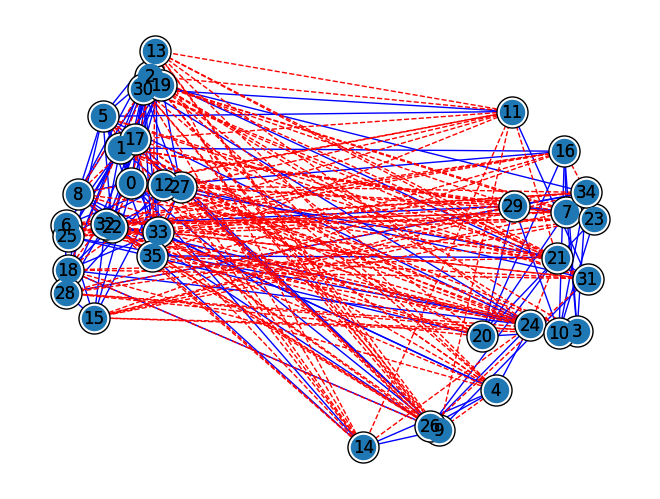

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

def plot_sparse_graph(H, out_png="graph.png"):
    # 어떤 희소형식이든 coo로 변환
    Hcoo = H.tocoo()

    G = nx.Graph()
    for i, j, v in zip(Hcoo.row, Hcoo.col, Hcoo.data):
        if i == j:          # 대각 성분은 self-loop라서 건너뜀
            continue
        if abs(v) < 1e-12:  # 너무 작은 값은 무시
            continue
        G.add_edge(i, j, weight=float(v))

    # 닫힌 사이클 찾기
    cycles = nx.cycle_basis(G)

    # 길이별로 묶기
    by_length = defaultdict(list)
    for cyc in cycles:
        by_length[len(cyc)].append(cyc)

    for L, group in sorted(by_length.items()):
        print(f"{L}-cycle ({len(group)}개):")
        for cyc in group:
            print("  ", cyc)

    #pos = nx.spring_layout(G, seed=42)
    pos = nx.spring_layout(G, weight='weight')

    # 양수/음수 간선 구분
    edges_pos = [(u,v) for u,v,d in G.edges(data=True) if d['weight'] > 0]
    edges_neg = [(u,v) for u,v,d in G.edges(data=True) if d['weight'] < 0]

    nx.draw(G, pos,
            node_color='white', edgecolors='black', node_size=500,
            edgelist=edges_pos, edge_color='blue', with_labels=True)
    nx.draw(G, pos,
            nodelist=G.nodes, edgelist=edges_neg,
            edge_color='red', style='dashed', with_labels=True)

    # 사이클 강조
    # for cyc in cycles:
    #     cyc_edges = list(zip(cyc, cyc[1:] + [cyc[0]]))
    #     nx.draw_networkx_edges(G, pos, edgelist=cyc_edges,
    #                            edge_color='green', width=3)

    plt.savefig(out_png, dpi=200)
    print("saved to", out_png)

# === 사용 예시 ===
# H가 csr_matrix, csc_matrix 등이라면 바로 전달 가능
plot_sparse_graph(H_N2_Sz0, "graph.png")

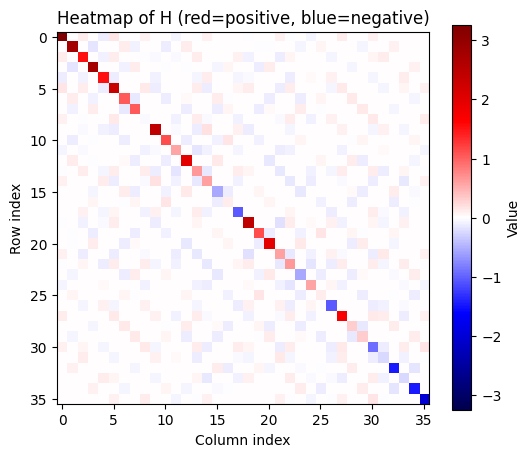

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# H: 희소행렬 (예: CSR/COO/CSC)
# 여기서는 예시로 만듦
# H = csr_matrix([[ 1, -2, 0],
#                 [ 0,  3, -4],
#                 [-1,  0,  2]])

# 1) dense array 변환
H_real = H_N2_Sz0.real
H_dense = H_real.toarray()


# 2) 히트맵 그리기
plt.figure(figsize=(6,5))

# 값 크기에 맞게 대칭적인 색범위 설정
vmax = np.abs(H_dense).max()

im = plt.imshow(H_dense, cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar(im, label="Value")

plt.title("Heatmap of H (red=positive, blue=negative)")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()

In [25]:
import numpy as np
import networkx as nx
from scipy.sparse import issparse, coo_matrix, csr_matrix, csc_matrix

def sparse_to_graph(A, *,
                    directed=False,
                    weight="value",   # "value" | "abs" | "binary"
                    symmetrize=True,  # 무향 그래프용: 패턴을 A + A.T로 합칠지
                    tol=0.0,          # |a_ij|<=tol 은 0 취급
                    keep_diagonal=False):
    """
    희소행렬 A -> NetworkX Graph/DiGraph 변환

    Parameters
    ----------
    A : scipy.sparse matrix (정방 추천)
    directed : bool
        True면 DiGraph, False면 Graph
    weight : {"value","abs","binary"}
        엣지 weight 설정 방법
        - "value": a_ij (실수/복소 가능; 복소는 실수부 사용 권장)
        - "abs"  : |a_ij|
        - "binary": 1 (연결만 표현)
    symmetrize : bool
        무향 그래프에서 A의 패턴을 A + A^T로 결합 (권장)
        directed=True 인 경우엔 무시됨
    tol : float
        임계값 이하 절댓값은 0으로 무시
    keep_diagonal : bool
        True면 i==j 항도 self-loop로 추가

    Returns
    -------
    G : nx.Graph or nx.DiGraph
    """
    if not issparse(A):
        raise ValueError("A must be a scipy.sparse matrix")
    # COO로 변환
    A = A.tocoo(copy=True)

    # tol 필터링
    if tol > 0:
        mask = np.abs(A.data) > tol
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 대각 요소 처리
    if not keep_diagonal:
        mask = A.row != A.col
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 무향이면 패턴 대칭화(권장): A <- A + A.T (중복은 합쳐짐)
    if not directed and symmetrize:
        AT = coo_matrix((A.data, (A.col, A.row)), shape=A.shape)
        A = (A + AT).tocoo()

    # 그래프 타입 선택
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(range(A.shape[0]))  # 노드: 0..n-1

    # weight 설정
    if weight == "binary":
        # 동일 (i,j) 중복 합치기 위해 집계
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, A.data):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] = 1.0  # 존재만 표시
        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    else:
        # "value" 또는 "abs"
        if weight == "abs":
            vals = np.abs(A.data)
        elif weight == "value":
            # 복소인 경우 실수부만 쓰고 싶다면 .real 사용
            # 필요에 따라 변경 가능: vals = np.real(A.data)
            vals = A.data
        else:
            raise ValueError("weight must be 'value', 'abs', or 'binary'")

        # 동일 엣지 중복 합치기(무향일 때 i<j 묶기)
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, vals):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] += float(v)  # 누적(합). 필요시 max/mean 등으로 변경 가능.

        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    return G

In [26]:
from scipy.sparse import csr_matrix


# 1) 무향 그래프 (구조적 연결성 확인용)
G = sparse_to_graph(H_real, directed=False, weight="abs", symmetrize=True, tol=0.0)

# 연결 성분
ccs = list(nx.connected_components(G))
print("연결 성분:", ccs)  # 예: [{0,1}, {2,3}]

# 각 성분의 서브그래프
subgraphs = [G.subgraph(S).copy() for S in ccs]


연결 성분: [{0, 2, 4, 5, 8, 9, 11, 13, 14, 17, 18, 21, 22, 24, 26, 27, 30, 31, 33, 35}, {32, 1, 34, 3, 6, 7, 10, 12, 15, 16, 19, 20, 23, 25, 28, 29}]


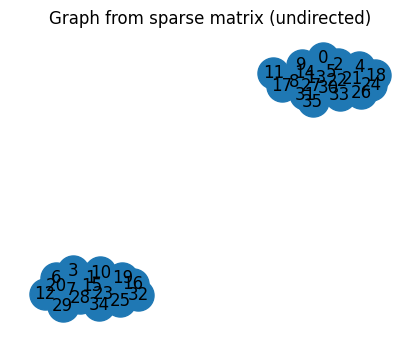

In [27]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, seed=0)
edge_w = [d["weight"] for *_, d in G.edges(data=True)]

plt.figure(figsize=(4,3))
nx.draw(G, pos, with_labels=True, node_size=500, width=edge_w)  # weight를 두께로
plt.title("Graph from sparse matrix (undirected)")
plt.show()

In [28]:
idx = [0, 2, 4, 5, 8, 9, 11, 13, 14, 17, 18, 21, 22, 24, 26, 27, 30, 31, 33, 35]

# 희소행렬 H에서 부분행렬 뽑기
H_sub = H_real[idx, :][:, idx]

w, V = eigsh(H_sub, k=1, which='SA') 
print(w)

[-2.0264693]
